In [45]:
from typing import *
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
import pandas as pd
sns.set_style("whitegrid")

In [46]:
import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.distributions import Distribution
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision import transforms, utils
from functools import reduce

# Flatten the images into a vector
flatten = lambda x: ToTensor()(x).view(28**2)
from torch.distributions import Bernoulli
from torch.distributions import Multinomial
binarization = lambda x: torch.bernoulli(x)
c_transform  = transforms.Compose([flatten,binarization])

# Define the train and test sets
dset_train = MNIST("./", train=True,  transform=c_transform, download=True)
dset_test  = MNIST("./", train=False, transform=c_transform)

# The digit classes to use
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

def stratified_sampler(labels):
    """Sampler that only picks datapoints corresponding to the specified classes"""
    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))
    indices = torch.from_numpy(indices)
    return SubsetRandomSampler(indices)

batch_size = 64
eval_batch_size = 64
# The loaders perform the actual work
train_loader = DataLoader(dset_train, batch_size=batch_size,
                          sampler=stratified_sampler(dset_train.train_labels))
test_loader  = DataLoader(dset_test, batch_size=eval_batch_size, 
                          sampler=stratified_sampler(dset_test.test_labels))

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


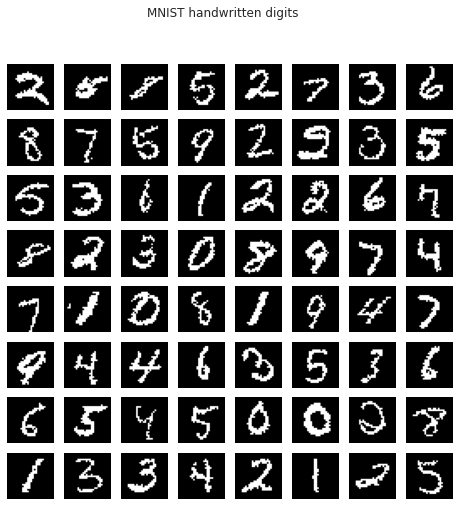

In [47]:
#plot a few MNIST examples
f, axarr = plt.subplots(8, 8, figsize=(8, 8))

# Load a batch of images into memory
images, labels = next(iter(train_loader))

for i, ax in enumerate(axarr.flat):
    ax.imshow(images[i].view(28, 28), cmap="binary_r")
    ax.axis('off')
    
plt.suptitle('MNIST handwritten digits')
plt.show()

# M2 Model

In [48]:
import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.distributions import Distribution


class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        
    def sample_epsilon(self) -> Tensor:
        """`\eps ~ N(0, I)`"""
        return torch.empty_like(self.mu).normal_()
        
    def sample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (without gradients)"""
        with torch.no_grad():
            return self.rsample()
        
    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        return self.mu + self.sigma * self.sample_epsilon()
        
    def log_prob(self, z:Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
        epsilon = (z-self.mu)/self.sigma
        return -1/2*epsilon**2-self.sigma.log()-(1/2)*math.log(2*math.pi)  

In [49]:
class VariationalAutoencoder(nn.Module):
    """A modified Variational Autoencoder with
    * a Bernoulli observation model `p_\theta(x | z) = B(x | g_\theta(z))`
    * a Gaussian prior `p(z) = N(z | 0, I)`
    * a Gaussian posterior `q_\phi(z|x) = N(z | \mu(x), \sigma(x))`
    """
    
    def __init__(self, input_shape:torch.Size, label_shape:torch.Size, latent_features:int) -> None:
        super(VariationalAutoencoder, self).__init__()
        
        self.input_shape = input_shape
        self.latent_features = latent_features
        self.observation_features = np.prod(input_shape)

        # Inference Networks
        self.encoder = nn.Sequential(
            nn.Linear(in_features=self.observation_features, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=2*latent_features) 
        )

        # Classifier Network
        self.classifier = nn.Sequential(
            nn.Linear(in_features=self.observation_features, out_features=10),
            nn.Softmax(dim=1)
        )

        # Generative Model
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features+10, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=self.observation_features)
        )
        
        # define the parameters of the prior, chosen as p(z) = N(0, I)
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))

    def posterior_labely(self, x:Tensor) -> Distribution:
        """return the distribution `q(y|x) = Cat(y|pi(x))`"""
        m = Multinomial(1, x)
        return m.sample()

    def posterior(self, x:Tensor) -> Distribution:
        """return the distribution `q(x|x) = N(z | \mu(x), \sigma(x))`"""
        # compute the parameters of the posterior
        h_x = self.encoder(x)
        mu, log_sigma =  h_x.chunk(2, dim=-1)
        # return a distribution `q(x|x) = N(z | \mu(x), \sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def prior(self, batch_size:int=1)-> Distribution:
        """return the distribution `p(z)`"""
        prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = prior_params.chunk(2, dim=-1) 
        # return the distribution `p(z)`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def observation_model(self, z:Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""
        px_logits = self.decoder(z)
        px_logits = px_logits.view(-1, *self.input_shape)
        return Bernoulli(logits=px_logits)
        
    def forward(self, x, y) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""
        
        # flatten the input
        x = x.view(x.size(0), -1)

        # Classify digit
        py = self.classifier(x)
        qy = self.posterior_labely(py)
        
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x)
        
        # define the prior p(z)
        pz = self.prior(batch_size=x.size(0))
        
        # sample the posterior using the reparameterization trick: z ~ q(z|x)
        z = qz.rsample()
        
        #Check label
        if (y.item() == 10) is False:
          y2 = torch.zeros(1, 10, dtype=torch.int64)
          y2[:, y.item()] = 1
        else:
          y2 = py
        
        # define the observation model p(x|z) = B(x | g(z))
        new_z = torch.cat((z,py), 1)
        px = self.observation_model(new_z)
        
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z, 'qy' : qy, 'py' : py}
    
    def sample_from_prior(self, batch_size:int=100):
        """sample z~p(z) and return p(x|z)"""
        
        # degine the prior p(z)
        pz = self.prior(batch_size=batch_size)
        
        # sample the prior 
        z = pz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'z': z}

latent_features = 2
vae = VariationalAutoencoder(images[0].shape, labels[0].shape, latent_features)
print(vae)

VariationalAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
    (1): Softmax(dim=1)
  )
  (decoder): Sequential(
    (0): Linear(in_features=12, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
  )
)


In [50]:
vae(torch.unsqueeze(images[0], 0), labels[0])

In [51]:
def reduce(x:Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    return x.view(x.size(0), -1).sum(dim=1)

class VariationalInference(nn.Module):
    def __init__(self, alpha:float=0.1):
        super().__init__()
        self.alpha = alpha
        
    def forward(self, model:nn.Module, x:Tensor, y:Tensor) -> Tuple[Tensor, Dict]:
        # forward pass through the model
        outputs = model(x,y)
          
        # unpack outputs
        px, pz, qz, z, qy, py = [outputs[k] for k in ["px", "pz", "qz", "z", "qy", "py"]]
        log_px = reduce(px.log_prob(x)).mean().repeat(10)
        log_pz = reduce(pz.log_prob(z)).repeat(10)
        log_qz = reduce(qz.log_prob(z)).repeat(10)
        log_py = torch.log(py)

        if (y.item() == 10) is True:
          L = - (log_px + log_py + log_pz - log_qz)
          loss = -( (torch.mul(qy,-L)).sum(1) + torch.mul(qy,log_py).sum(1))
        else:
          L = - (log_px + log_py + log_pz - log_qz)   
          loss = L[:,y.item()] - (self.alpha * qy[:,y.item()])

        return loss

In [52]:
vi = VariationalInference(alpha=0.1)
loss = vi(vae, torch.unsqueeze(images[0], 0), labels[0])

# Training

In [66]:
from collections import defaultdict
# define the models, evaluator and optimizer

# VAE
latent_features = 4 #2
vae = VariationalAutoencoder(images[0].shape, labels[0].shape, latent_features)

# Evaluator: Variational Inference
alpha = 0.1
vi = VariationalInference(alpha=alpha)

# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
r_images = torch.load("drive//My Drive/Vae/r_images.pt")
r_labels = torch.load("drive//My Drive/Vae/r_labels.pt")
r_labels = r_labels.type(torch.LongTensor)

In [67]:
import torch.optim as optim
import random

for epoch in range(10):
  running_loss = 0
  vae.train()
  for j in range(1000):
    n = random.randint(0,99)
    x = r_images[n,]        
    y = r_labels[n] 
    optimizer.zero_grad()
    x = torch.unsqueeze(x, 0)
    output = vae(x,y)
    loss = vi(vae, x, y) 
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  print('[%d] loss: %.3f' % (epoch, running_loss/1000) )

[0] loss: 215.796
[1] loss: 149.389
[2] loss: 128.845
[3] loss: 114.479
[4] loss: 104.353
[5] loss: 93.851
[6] loss: 85.870
[7] loss: 78.645
[8] loss: 73.258
[9] loss: 67.312


In [75]:
path = "drive//My Drive/M2_Vae_0.pt"
torch.save(vae, path)

In [68]:
correct = 0
total = 0

with torch.no_grad():
      for i in range(100):
        x = r_images[i,]        
        y = r_labels[i] 
        x = torch.unsqueeze(x, 0)
        outputs = vae(x,y)
        px, pz, qz, z, qy, py = [outputs[k] for k in ["px", "pz", "qz", "z", "qy", "py"]]
        _, predicted = torch.max(py, 1)
        #print(y,predicted)
        total += 1
        correct += (predicted == y).sum().item()
print('Accuracy: %f %%' % (100 * correct / total))

Accuracy: 80.000000 %


In [69]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
      images, labels = data
      for i in range(labels.shape[0]-1):
        x = images[i,]        
        y = labels[i] 
        x = torch.unsqueeze(x, 0)
        outputs = vae(x,y)
        px, pz, qz, z, qy, py = [outputs[k] for k in ["px", "pz", "qz", "z", "qy", "py"]]
        _, predicted = torch.max(py, 1)
        total += 1
        correct += (predicted == y).sum().item()
print('Accuracy: %f %%' % (100 * correct / total))

Accuracy: 67.621660 %
